# Spokane Solar Suitability
### Areeba Usman & Rose Martin
---

## Background & Problem Statement

<img src="https://images.unsplash.com/photo-1508514177221-188b1cf16e9d?fm=jpg&q=60&w=3000&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8Mnx8c29sYXIlMjBmYXJtfGVufDB8fDB8fHww" alt="Spokane Map" width="1200"/>

### This projects aims to determine an area of land to place a solar farm on in Spokane County
### Paramaters are that it must be atleast 150 acres of land, away from a flood zone but close proximity to substations which can easily develop and maintain solar farms.
### We will also consider average radiation, elevation, and land use to ensure that our proposal does not disrupt the communities and environment in Spokane.
####
---

# Section 0: Install & Importing Packages

## Run data_download.ipynb before use

In [1]:
!pip install -q censusdata

In [2]:
import os
import shutil
import zipfile
import requests
import censusdata
import rasterstats
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import rasterio as rio
import geopandas as gpd
import rioxarray as rxr
from pathlib import Path
import contextily as ctx
from affine import Affine
from scipy.ndimage import label
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import xyzservices.providers as xyz
from rasterio.features import rasterize
from rasterio import plot, mask, features
from rasterio.transform import from_origin
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Point, Polygon, shape, box
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Section 1: Loading Zone
- Loads data as rio rasters
- Creates AEA Projection

### Census Data 
#### Functions from Lab 5

In [3]:
def get_census_data(tables, state, county, year=2019):
    '''Download census data for a given state and county fips code.'''

    # Download the data
    data = censusdata.download('acs5', year,  # Use 2019 ACS 5-year estimates
                               censusdata.censusgeo([('state', state), ('county', county), ('tract', '*')]),
                               list(tables.keys()))

    # Rename the column
    data.rename(columns=tables, inplace=True)

    # Extract information from the first column
    data['Name'] = data.index.to_series().apply(lambda x: x.name)
    data['SummaryLevel'] = data.index.to_series().apply(lambda x: x.sumlevel())
    data['State'] = data.index.to_series().apply(lambda x: x.geo[0][1])
    data['County'] = data.index.to_series().apply(lambda x: x.geo[1][1])
    data['Tract'] = data.index.to_series().apply(lambda x: x.geo[2][1])
    data.reset_index(drop=True, inplace=True)
    data = data[['Tract','Name']+list(tables.values())].set_index('Tract')
    
    return data

In [4]:
def get_census_tract_geom(state_fips, county_fips):
    '''Download census tract geometries for a given state and county fips code, storing in /tmp and cleaning up after.'''

    temp_dir = "/tmp/census_tracts"
    zip_path = os.path.join(temp_dir, f'tl_2019_{state_fips}_tract.zip')

    # Ensure temp directory exists
    os.makedirs(temp_dir, exist_ok=True)

    # Download the file
    url = f'https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_{state_fips}_tract.zip'
    response = requests.get(url, stream=True)
    if response.status_code != 200:
        raise Exception(f"Failed to download file: {url}")

    # Save ZIP file to temp directory
    with open(zip_path, "wb") as file:
        file.write(response.content)

    # Extract the ZIP file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(temp_dir)

    # Find the shapefile in extracted contents
    for file in os.listdir(temp_dir):
        if file.endswith(".shp"):
            shapefile_path = os.path.join(temp_dir, file)
            break

    # Read the shapefile into a GeoDataFrame
    tracts = gpd.read_file(shapefile_path)

    # Filter by county and set index
    tracts = tracts[tracts['COUNTYFP'] == county_fips]
    tracts = tracts.rename(columns={'TRACTCE': 'Tract'}).set_index('Tract')

    # Cleanup: Remove extracted files and ZIP file
    shutil.rmtree(temp_dir)

    return tracts[['geometry']]

In [5]:
tables = {
'B19013_001E': 'MedianIncome',
'B01003_001E': 'TotalPopulation',
'B25064_001E': 'MedianGrossRent',
'B25077_001E': 'MedianHomeValue',
'B25035_001E': 'MedianYearStructureBuilt',
'B25001_001E': 'TotalHousingUnits',
'B25004_001E': 'TotalVacantHousingUnits',
'B25003_002E': 'OccupiedHousingUnitsOwnerOccupied',
'B25003_003E': 'OccupiedHousingUnitsRenterOccupied',
}

## FIPS Code for Washington
state_fips = '53' 

## FIPS code for Spokane County
county_fips = '063'  

In [6]:
## Data
census_df = get_census_data(tables, state_fips, county_fips)
## Geometry
tract_geom_gdf = get_census_tract_geom(state_fips, county_fips)
## Projection Placeholder
tract_geom_gdf_fo_proj = tract_geom_gdf

# Joining geometries to spokane census data
census_Spokane_gdf = gpd.GeoDataFrame(census_df.join(tract_geom_gdf))
census_Spokane_gdf =  census_Spokane_gdf.to_crs('epsg:32610')
census_df.head()

,Name,MedianIncome,TotalPopulation,MedianGrossRent,MedianHomeValue,MedianYearStructureBuilt,TotalHousingUnits,TotalVacantHousingUnits,OccupiedHousingUnitsOwnerOccupied,OccupiedHousingUnitsRenterOccupied
Tract,,,,,,,,,,
014500,"Census Tract 145, Spokane County, Washington",26250,1954,693,126100,1941,952,161,214,577
012100,"Census Tract 121, Spokane County, Washington",51223,2627,1000,161500,1958,1235,53,824,358
002100,"Census Tract 21, Spokane County, Washington",54620,2483,843,145500,0,1109,16,617,476
010301,"Census Tract 103.01, Spokane County, Washington",52531,4795,784,199000,1983,1890,115,1435,340
011102,"Census Tract 111.02, Spokane County, Washington",40671,4527,853,181000,1980,1732,74,457,1201


## AEA Projection Around Spokane

Creates an equal area projection that is later applied to all the raster to ensure the same projection is used and that later area calculations are accurate. 

In [7]:
#Creates a hull and then gets the centriod of the Spokane Country tract
hull = tract_geom_gdf_fo_proj.geometry.unary_union.convex_hull
cent = hull.centroid

#Saves the x,y coordinates of the centriod as well as the min and max latitude values for application in the equal area projection
cent_lon =cent.x
cent_lat = cent.y
min_lat = tract_geom_gdf_fo_proj.bounds["miny"].min().item()
max_lat = tract_geom_gdf_fo_proj.bounds["maxy"].max().item()

/tmp/ipykernel_1002/2711086677.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  hull = tract_geom_gdf_fo_proj.geometry.unary_union.convex_hull


In [8]:
#Creates a projection centered in the middle of Spokane County
proj_str_aea = f'+proj=aea +lat_1={min_lat:0.2f} +lat_2={max_lat:0.2f} +lat_0={cent_lat:0.2f} +lon_0={cent_lon:0.2f}'
print(proj_str_aea)

+proj=aea +lat_1=47.26 +lat_2=48.05 +lat_0=47.64 +lon_0=-117.42


## Flood Plains Data

In [9]:
floodplain_buffer_fn = "./Data/floodplain_with_buffer.tif"
floodplain_buffer_data = rxr.open_rasterio(floodplain_buffer_fn).squeeze()

## Slope Data

In [10]:
slope_fn = "./Data/WA_COP90_utm_gdalwarp_slope.tif"
slope_ras = rxr.open_rasterio(slope_fn, masked=True).squeeze()

## Substation Distance Data

In [11]:
substation_distance_raster_fn = "./Data/substations.tif"
substation_distance_raster_data = rxr.open_rasterio(substation_distance_raster_fn).squeeze()

## Radiation Data

In [12]:
radiation_fn = "./Data/radiation.tif"
radiation = rxr.open_rasterio(radiation_fn).squeeze()

## Land Use Data

In [13]:
land_use_fn = "./Data/land_use.tif"
land_use_da = rxr.open_rasterio(land_use_fn).squeeze()

---

# Section 2A: Data Prep
- Reprojecting to AEA Proj
- Clipping data to remove protected places
- Resolution match

### CRS Projection Match to Spokane AEA 

In [14]:
slope_ras = slope_ras.rio.reproject(proj_str_aea)

land_use_da = land_use_da.rio.reproject(proj_str_aea)

radiation = radiation.rio.reproject(proj_str_aea)

census_Spokane_gdf = census_Spokane_gdf.to_crs(proj_str_aea)

tract_geom_gdf = tract_geom_gdf.to_crs(proj_str_aea)

### Clipping all data to available land in Spokane

In [15]:
#Gets the outline of Spokane Country, used to clip the data to 
census_geom = census_Spokane_gdf.geometry.unary_union

#Clips the various rasters to be exactly within Spokane County
slope = slope_ras.rio.clip([census_geom])

land_use = land_use_da.rio.clip([census_geom])

radiation = radiation.rio.clip([census_geom])

substation_distance = substation_distance_raster_data.rio.clip([census_geom])

floodplain_buffer = floodplain_buffer_data.rio.clip([census_geom])

/tmp/ipykernel_1002/2320798212.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  census_geom = census_Spokane_gdf.geometry.unary_union


### Matching Resolutions

In [16]:
print(radiation.rio.resolution(), 
      slope.rio.resolution(), 
      land_use.rio.resolution(),
      substation_distance.rio.resolution(),
      floodplain_buffer.rio.resolution())

(748.2422257325958, -748.2422257325958) (68.72899148091128, -68.72899148091122) (93.53027821657551, -93.53027821657551) (100.0, -100.0) (100.0, -100.0)


In [17]:
#Projects the three rasters to a resolution of 100, -100 by matching it to floodplain resoltuion 

land_use = land_use_da.rio.reproject_match(floodplain_buffer_data)

radiation = radiation.rio.reproject_match(floodplain_buffer_data)

slope = slope.rio.reproject_match(floodplain_buffer_data)

In [18]:
print(radiation.rio.resolution(), 
      slope.rio.resolution(), 
      land_use.rio.resolution(),
      substation_distance.rio.resolution(),
      floodplain_buffer.rio.resolution())

(100.0, -100.0) (100.0, -100.0) (100.0, -100.0) (100.0, -100.0) (100.0, -100.0)


# What does all of this look like so far?

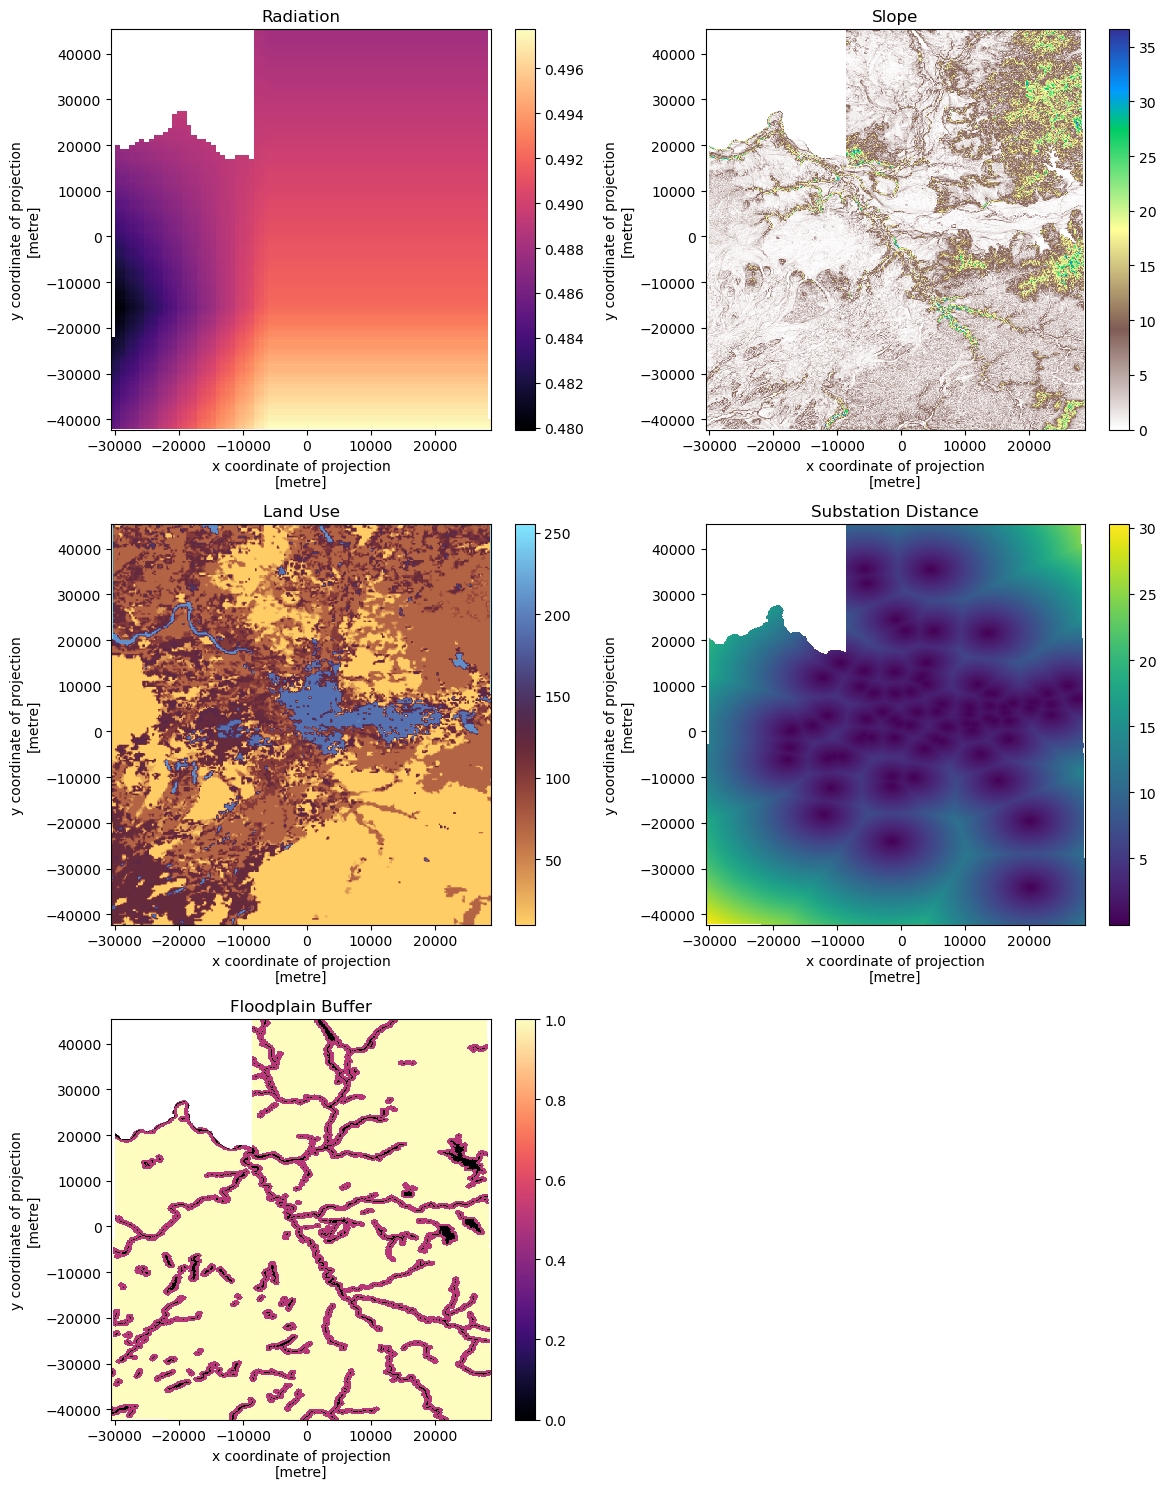

In [19]:
ds = [radiation, slope, land_use, substation_distance, floodplain_buffer]
titles = ['Radiation', 'Slope', 'Land Use', 'Substation Distance', 'Floodplain Buffer']
cmap = ['magma', 'terrain_r', 'managua', 'viridis', 'magma']

n_rows = (len(ds) + 1) // 2

fig, axs = plt.subplots(n_rows, 2, figsize=(12, n_rows * 5))

axs = axs.flatten()

for i, (data, title, cmap) in enumerate(zip(ds, titles, cmap)):
    data.plot(ax=axs[i], cmap=cmap)
    axs[i].set_title(title)
    axs[i].axis('on')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

---
# Section 2B
- Merging all data to XDarray Dataframe
- Summary Table

In [20]:
#Assign names to all of the rasters
floodplain_buffer.name = 'Flood_Zones'
substation_distance.name = 'Substation_Distance'
radiation.name = 'Radiation'
land_use.name = 'Land_Use'
slope.name = 'Slope'

# Merge the rasters together into a xarray
merged_df = xr.merge([floodplain_buffer, 
                      slope, 
                      substation_distance, 
                      radiation, 
                      land_use])

In [21]:
merged_df

<xarray.Dataset> Size: 11MB
Dimensions:              (x: 593, y: 876)
Coordinates:
    band                 int64 8B 1
  * x                    (x) float64 5kB -3.05e+04 -3.04e+04 ... 2.87e+04
  * y                    (y) float64 7kB 4.53e+04 4.52e+04 ... -4.22e+04
    spatial_ref          int64 8B 0
Data variables:
    Flood_Zones          (y, x) float32 2MB nan nan nan nan ... 1.0 1.0 1.0 1.0
    Slope                (y, x) float32 2MB nan nan nan ... 1.722 3.648 4.064
    Substation_Distance  (y, x) float32 2MB nan nan nan ... 11.57 11.64 11.71
    Radiation            (y, x) float64 4MB nan nan nan nan ... nan nan nan nan
    Land_Use             (y, x) uint8 519kB 255 255 255 113 69 ... 11 11 11 11
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [22]:
summary_table = merged_df.mean()
summary_table = merged_df.to_dataframe().describe()

In [23]:
summary_table

,band,spatial_ref,Flood_Zones,Slope,Substation_Distance,Radiation,Land_Use
count,519468.0,519468.0,461258.000000,460998.000000,461258.000000,458396.000000,519468.000000
mean,1.0,0.0,0.883075,4.509359,7.277742,0.490318,68.185367
std,0.0,0.0,0.242088,4.805049,5.613572,0.003321,49.098074
min,1.0,0.0,0.000000,0.000000,0.001652,0.479920,10.000000
25%,1.0,0.0,1.000000,1.239282,2.873534,0.488473,11.000000
50%,1.0,0.0,1.000000,2.764298,5.769769,0.490086,70.000000
75%,1.0,0.0,1.000000,5.866032,10.252606,0.492004,100.000000
max,1.0,0.0,1.000000,36.582905,30.263113,0.497737,255.000000


---
# Section 3: Scales & Classes 

In [24]:
#Create a copy of the merged xarray to prevent overwritting 
scale = merged_df.copy()

### Land Use

In [25]:
# Always reference original values from merged_df, ensuring that things are not being overwritten in the original
original_values = merged_df["Land_Use"]

scale['Land_Use'] = xr.where((original_values >= 150) & (original_values <= 180) | (original_values >= 210), np.nan, scale['Land_Use'])  # Water/Snow
scale['Land_Use'] = xr.where((original_values == 190), np.nan, scale['Land_Use'])  # Urban Areas
scale['Land_Use'] = xr.where((original_values >= 10) & (original_values <= 20), 3, scale['Land_Use'])  # Farmland 
scale['Land_Use'] = xr.where((original_values >= 50) & (original_values <= 90) | (scale['Land_Use'] == 100), np.nan, scale['Land_Use'])  # Forests
scale['Land_Use'] = xr.where((original_values == 200), 6, scale['Land_Use'])  # Bare Areas
scale['Land_Use'] = xr.where((original_values == 30) | (original_values >= 110) & (scale['Land_Use'] <= 140), 5, scale['Land_Use']) # Grasslands

### Flood Zones

In [26]:
#For all values mutliply them by 6, if the value was originally 1 thatn it will be viable adn will become a 6, if 0 it will stay 0 and if in a buffer zone 
#  an area that is less ideal the value will be a 3.
scale["Flood_Zones"] = merged_df.Flood_Zones * 6

### Substation Distances

In [27]:
# Always reference original values from merged_df, ensuring that things are not being overwritten in the original
original_values = merged_df["Substation_Distance"]

# Only update values in scale without overwriting previous changes
# The closer the pixel is to the substation, aka the shorter the distance, the more desirable the location and the higher the score value
scale["Substation_Distance"] = xr.where(original_values <= 2.5, 6, scale["Substation_Distance"])
scale["Substation_Distance"] = xr.where((original_values > 2.5) & (original_values <= 5), 5, scale["Substation_Distance"])
scale["Substation_Distance"] = xr.where((original_values > 5) & (original_values <= 7.5), 4, scale["Substation_Distance"])
scale["Substation_Distance"] = xr.where((original_values >= 7.5) & (original_values < 10), 3, scale["Substation_Distance"])
scale["Substation_Distance"] = xr.where((original_values > 10) & (original_values <= 15), 2, scale["Substation_Distance"])
scale["Substation_Distance"] = xr.where((original_values > 15), 1, scale["Substation_Distance"])

### Slope

In [28]:
original_values = merged_df["Slope"]

# Slope is ranked by the best, 6, being the lowest slopes, and the worst, one being the steepest
scale["Slope"] = xr.where(original_values <= 5, 6, scale["Slope"])
scale["Slope"] = xr.where((original_values > 5) & (original_values <= 10), 5, scale["Slope"])
scale["Slope"] = xr.where((original_values > 10) & (original_values <= 15), 4, scale["Slope"])

#Any slope above 15 too steep to be considered and gets a value of one
scale["Slope"] = xr.where(original_values >= 15, 1, scale["Slope"])

### Radiation

In [29]:
#Gets the min max and standard deviation to evenly distribute the score value
min_value = merged_df["Radiation"].min().item()
max_value = merged_df["Radiation"].max().item()
range_values = (max_value - min_value)/ 6

In [30]:
original_values = merged_df["Radiation"]

# Values seperated in even intervals as the raditiation values in Spokane are all above what is required for a solar farm
scale["Radiation"] = xr.where((original_values > (max_value-range_values)) & (original_values <= max_value), 6, scale["Radiation"])
scale["Radiation"] = xr.where((original_values > (max_value-range_values*2)) & (original_values <= (max_value - range_values)), 5, scale["Radiation"])
scale["Radiation"] = xr.where((original_values > (max_value - range_values*3)) & (original_values <= (max_value - 2*range_values)), 4, scale["Radiation"])
scale["Radiation"] = xr.where((original_values >= (min_value+ 2* range_values)) & (original_values <= (min_value + 3*range_values)), 3, scale["Radiation"])
scale["Radiation"] = xr.where((original_values >= (min_value+range_values)) & (original_values <= (min_value + 2*range_values)), 2, scale["Radiation"])
scale["Radiation"] = xr.where((original_values >= (min_value)) & (original_values <= (min_value + range_values)), 1, scale["Radiation"])

## Removing areas where land use and flood zones are nan

In [31]:
## removes all the spots that are ether nan or 0, aka areas that are have been marksed as flood plains or land use zones that cannot be used.
scale = scale.where((scale.Flood_Zones.notnull()) & (scale.Flood_Zones != 0), drop=True)
scale = scale.where((scale.Land_Use.notnull()) & (scale.Land_Use != 0), drop=True)

# How we lookin

Subplots of the score values for the various data arrays.

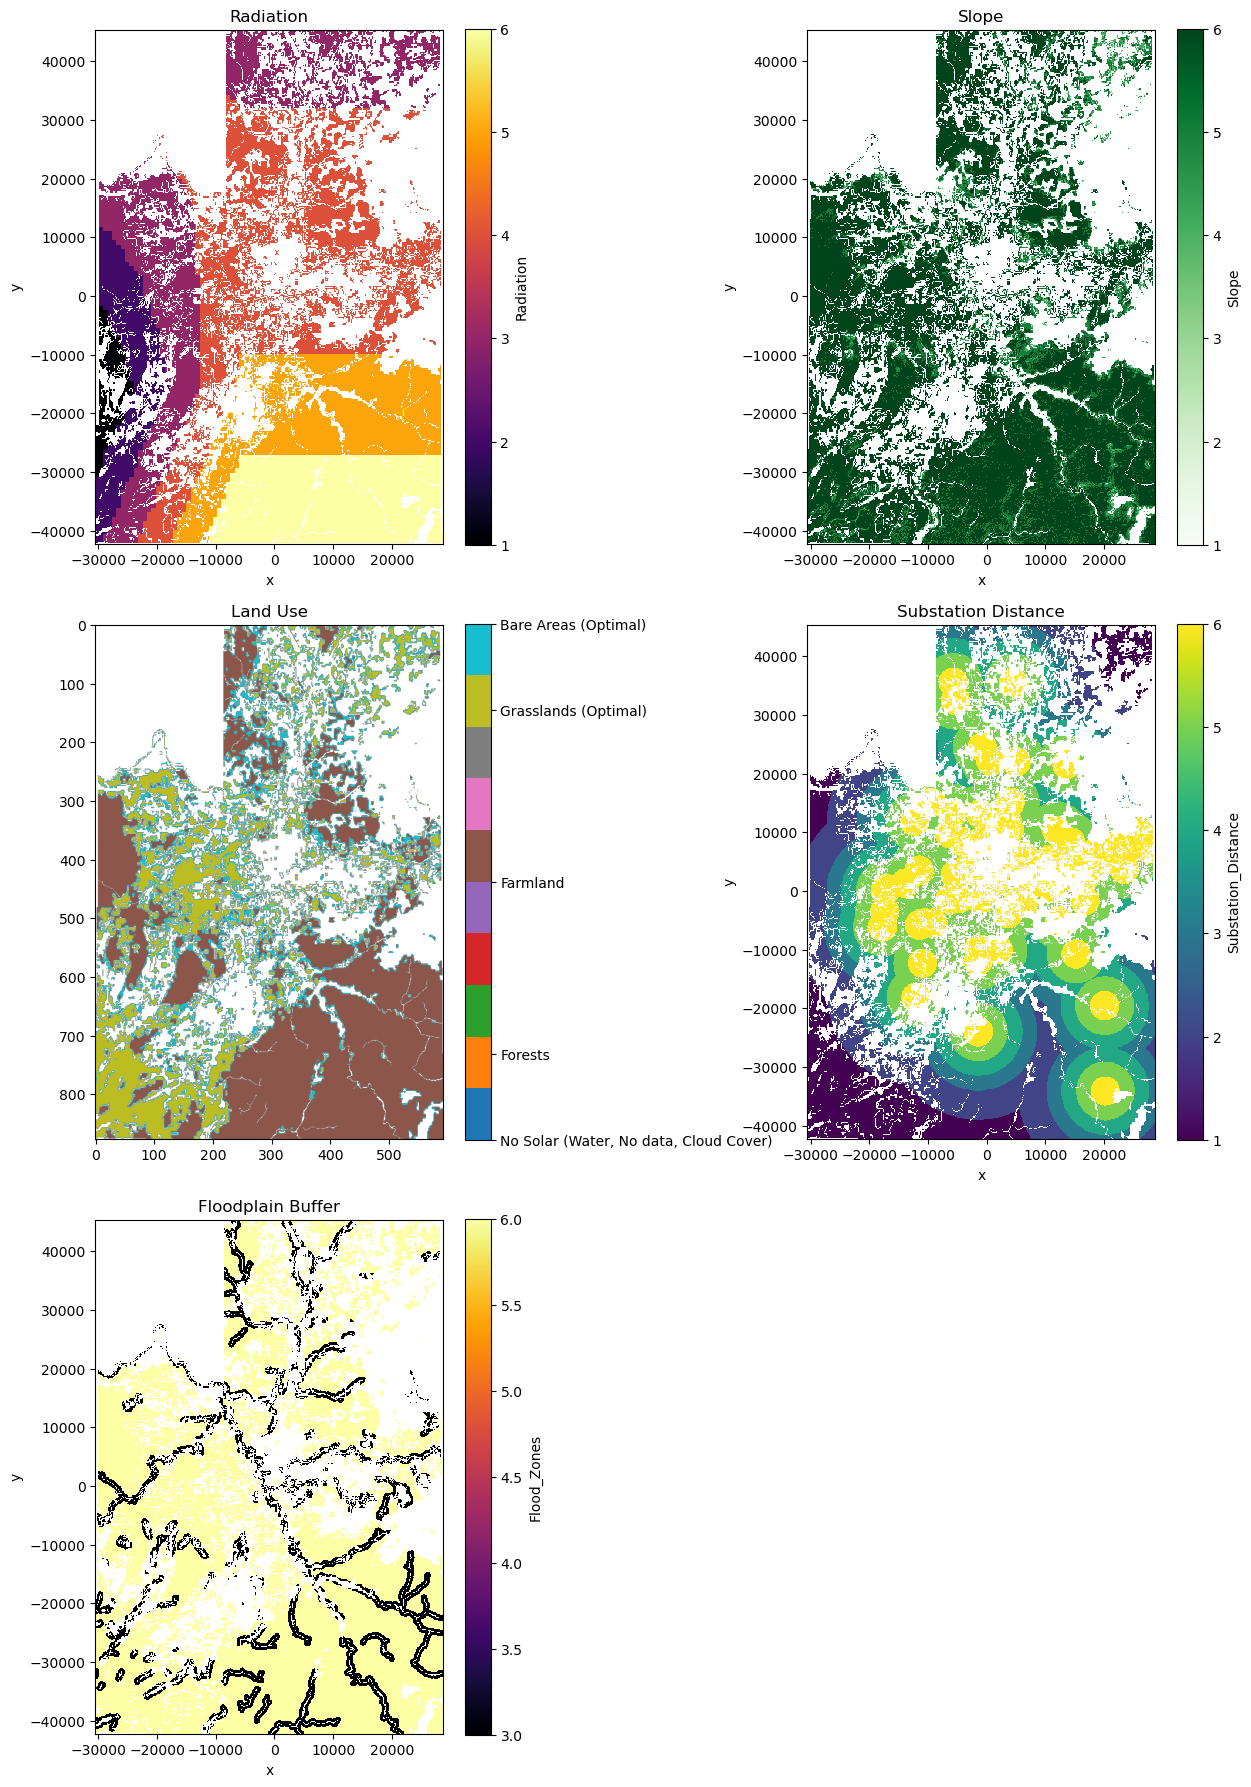

In [32]:
land_use_labels = {
    0: "No Solar (Water, No data, Cloud Cover)",
    1: "Forests",
    3: "Farmland",
    5: "Grasslands (Optimal)",
    6: "Bare Areas (Optimal)"
}
land_use_plot = scale["Land_Use"]

# Update the dataset to use numeric values for Land_Use
ds = [scale["Radiation"], scale["Slope"], land_use_plot, scale["Substation_Distance"], scale["Flood_Zones"]]
titles = ['Radiation', 'Slope', 'Land Use', 'Substation Distance', 'Floodplain Buffer']
cmap = ['inferno', 'Greens', 'Dark2', 'viridis', 'inferno']

n_rows = (len(ds) + 1) // 2
fig, axs = plt.subplots(n_rows, 2, figsize=(12, n_rows * 6))

axs = axs.flatten()

for i, (data, title, colormap) in enumerate(zip(ds, titles, cmap)):
    if title == "Land Use":
        im = axs[i].imshow(data, cmap='tab10', vmin=0, vmax=6)  # Adjust colormap for categorical data
        cbar = fig.colorbar(im, ax=axs[i], ticks=list(land_use_labels.keys()))
        cbar.ax.set_yticklabels(list(land_use_labels.values()))
    else:
        data.plot(ax=axs[i], cmap=colormap)
    axs[i].set_title(title)
    axs[i].set_aspect('equal')
    axs[i].axis('on')

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

# Section 4: Score Weight Calculation

In [33]:
# It was determined that the score would be weighted based on the importance/influence of the variable
# The weight was based on what we thoguht was most important but was also somewhat arbitrary


net_score_unweighted = scale["Radiation"] + scale["Slope"] + scale["Substation_Distance"] + scale["Flood_Zones"]
net_score_weighted = scale["Radiation"] * 0.75 + scale["Slope"] * 1.25 + scale["Substation_Distance"] * 1 + scale["Flood_Zones"] * 0.25

scale["net_score_weighted"] = net_score_weighted
scale['net_score_unweighted']= net_score_unweighted

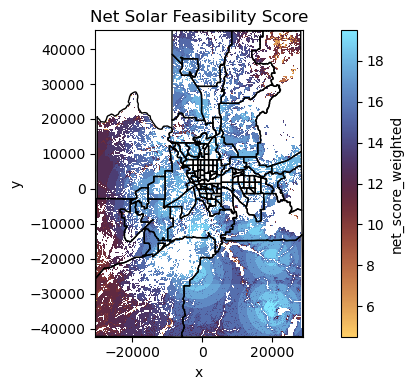

In [34]:
fig,ax = plt.subplots(figsize=(8, 4))
scale.net_score_weighted.plot(ax=ax, cmap='managua')
tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none')
plt.title("Net Solar Feasibility Score")

plt.tight_layout()
plt.show()
#substation_gdf.plot(ax=ax, color='red', edgecolor='k',alpha=0.7)

# Section 5: Finding 150 acre-ft areas

The raster above is comprised of the net score of each pixel based on the variables at that spot. Each pixel is 100 meters by 100 meters. 
This code identifies areas of at least 200 acres that do not include any nans and calculates the net score of the area. This code was written with the assitance of chatGPT.

In [35]:
data = net_score_unweighted.values
pixel_size = 100  # meters

## Note: Cange the desired area size, in acres
area = 150

#Conversion of acres to m^2
acre_in_m2 = 4046.86

# side length in meters (~636.37 m)
cell_area_m2 = area * acre_in_m2       
cell_side = np.sqrt(cell_area_m2)     

In [36]:
# Get the raster bounds based on the xarray coordinates.
x_coords = net_score_unweighted.coords['x'].values
y_coords = net_score_unweighted.coords['y'].values

In [37]:
# Assuming x and y are pixel center coordinates, compute the full extent:
x_min = x_coords[0] - pixel_size/2
x_max = x_coords[-1] + pixel_size/2
if y_coords[0] > y_coords[-1]:
    # y is descending (common in rasters)
    y_max = y_coords[0] + pixel_size/2
    y_min = y_coords[-1] - pixel_size/2
else:
    y_min = y_coords[0] - pixel_size/2
    y_max = y_coords[-1] + pixel_size/2

In [38]:
# Set up the affine transform for the raster.
# (This assumes the raster is north-up; adjust if your coordinate system is different.)
if y_coords[0] > y_coords[-1]:
    transform = Affine(pixel_size, 0, x_min,
                       0, -pixel_size, y_max)
else:
    transform = Affine(pixel_size, 0, x_min,
                       0, pixel_size, y_min)

In [39]:
# Build a grid covering the raster extent with cells of size "cell_side" x "cell_side".
grid_polygons = []
current_x = x_min
while current_x < x_max:
    current_y = y_min
    while current_y < y_max:
        # Create a polygon for this grid cell.
        cell_poly = box(current_x, current_y, current_x + cell_side, current_y + cell_side)
        grid_polygons.append(cell_poly)
        current_y += cell_side
    current_x += cell_side

In [40]:
# A helper function to compute pixel window indices for a given real-world bounding box.
def get_window_indices(xmin, xmax, ymin, ymax, transform, shape):
    inv_transform = ~transform
    # For a box, compute the indices for the top-left and bottom-right corners.
    col_min, row_min = map(int, inv_transform * (xmin, ymax))
    col_max, row_max = map(int, inv_transform * (xmax, ymin))
    # Clamp indices to the data array bounds.
    row_min = max(0, row_min)
    row_max = min(shape[0], row_max + 1)
    col_min = max(0, col_min)
    col_max = min(shape[1], col_max + 1)
    return row_min, row_max, col_min, col_max

In [41]:
# Loop over each grid cell. For each, we extract the subset of pixel values
# that lie within its bounding box and then verify (using the pixel center coordinates)
# that every pixel falling inside the cell is non-NaN.
cells = []
net_scores = []
for poly in grid_polygons:
    # Get the bounds of the polygon.
    xmin, ymin, xmax, ymax = poly.bounds
    # Get corresponding pixel indices.
    row_min, row_max, col_min, col_max = get_window_indices(xmin, xmax, ymin, ymax, transform, data.shape)
    if row_max <= row_min or col_max <= col_min:
        continue
    window_data = data[row_min:row_max, col_min:col_max]
    
    # Build a grid of pixel center coordinates for the window.
    rows, cols = np.indices(window_data.shape)
    # Compute real-world coordinates for each pixel center.
    xs, ys = transform * (cols + col_min + 0.5, rows + row_min + 0.5)
    
    # Create a mask: True for pixels whose center falls within the polygon.
    # (Note: This approach iterates over each pixel center.)
    inside = np.array([poly.contains(Point(x, y)) for x, y in zip(xs.ravel(), ys.ravel())])
    inside_mask = inside.reshape(window_data.shape)
    
    # If any pixel within the cell is NaN, skip this cell.
    if np.isnan(window_data[inside_mask]).any():
        continue
    
    # Sum the net score for pixels whose centers lie within the cell.
    cell_net_score = np.sum(window_data[inside_mask])
    cells.append(poly)
    net_scores.append(cell_net_score)

In [42]:
# Create a GeoDataFrame with the resulting grid cells and net score sums.
potential_solar_lands_gdf = gpd.GeoDataFrame({'net_score': net_scores, 'geometry': cells}, crs=proj_str_aea)
potential_solar_lands_gdf

,net_score,geometry
0,959.0,"POLYGON ((-28990.662 -39136.554, -28990.662 -3..."
1,959.0,"POLYGON ((-28990.662 -36020.071, -28990.662 -3..."
2,751.0,"POLYGON ((-28990.662 -33682.709, -28990.662 -3..."
3,958.0,"POLYGON ((-28990.662 -32903.589, -28990.662 -3..."
4,958.0,"POLYGON ((-28990.662 -32124.468, -28990.662 -3..."
...,...,...
1774,1232.0,"POLYGON ((27885.146 8389.806, 27885.146 9168.9..."
1775,1279.0,"POLYGON ((28664.266 -41473.916, 28664.266 -406..."
1776,1133.0,"POLYGON ((28664.266 -40694.795, 28664.266 -399..."
1777,159.0,"POLYGON ((29443.387 -41473.916, 29443.387 -406..."


<Axes: ylabel='Frequency'>

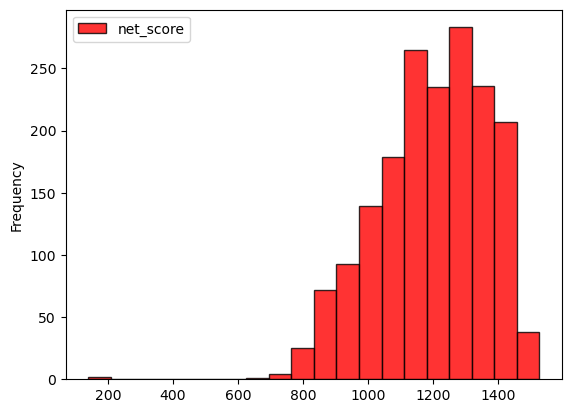

In [43]:
potential_solar_lands_gdf.plot.hist(facecolor='red', edgecolor='black', alpha=0.8, bins=20)

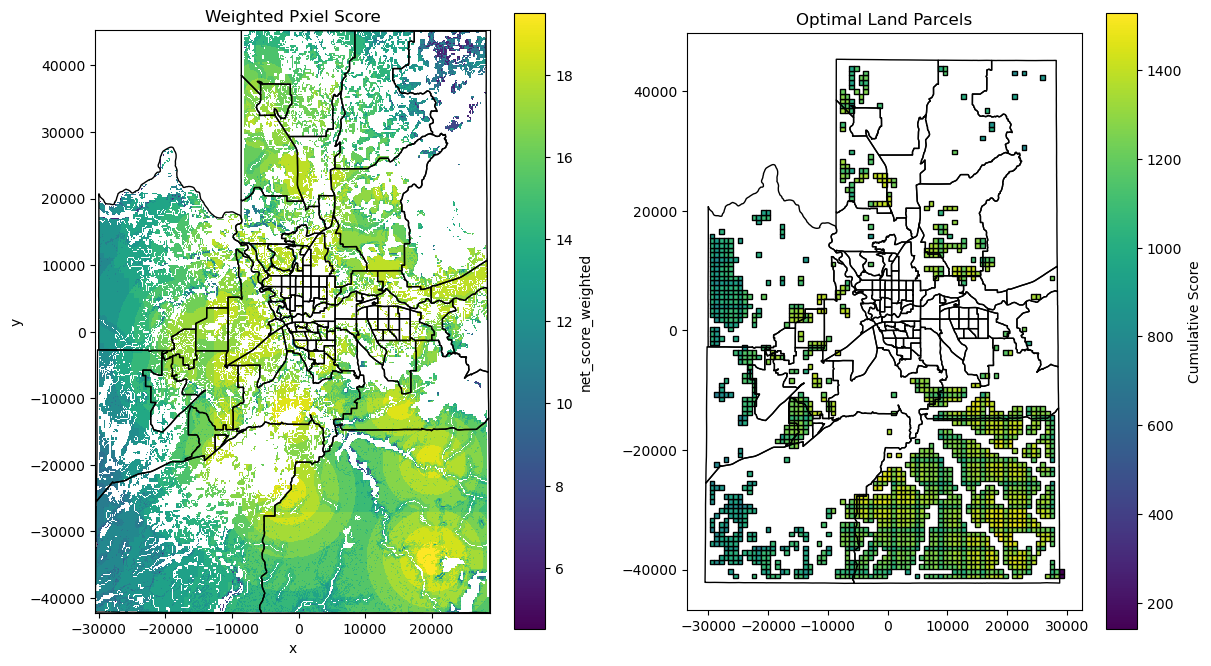

In [44]:
fig, ax = plt.subplots(1,2,figsize=(14, 8))

scale.net_score_weighted.plot(ax=ax[0])
tract_geom_gdf.plot(ax=ax[0], facecolor = 'none')

potential_solar_lands_gdf.plot(column="net_score", cmap="viridis", edgecolor="black", legend=True, ax=ax[1], legend_kwds={"label":"Cumulative Score"})
tract_geom_gdf.plot(ax=ax[1], edgecolor="black", facecolor = 'none')

ax[0].set_title("Weighted Pxiel Score")
ax[1].set_title("Optimal Land Parcels")

plt.show()

## Filter Results

Select the highest scoring parcels of land. Note the maximum value changes based on the size of the land parcel, whether it be 100, 150, or 200 acres. This issue is remedied by selecting the top two percentile of the availble options.

In [45]:
#Gets the value of the 98th percentile
top_2_percentile = potential_solar_lands_gdf.net_score.quantile(0.98)

#Returns true for all values about the 98th percentile and false for those below it, and saves the values to a seperate dataframe
gdf_filter_id = potential_solar_lands_gdf.net_score > top_2_percentile
potential_solar_gdf_filter = potential_solar_lands_gdf[gdf_filter_id]

print("\nFiltering out results under the 98th precentile returns", len(potential_solar_gdf_filter), "possible solar farm locations. \n")


Filtering out results under the 98th precentile returns 35 possible solar farm locations. 



### Tract Numbers

Gets the tract number for the areas where solar farms may be placed

In [46]:
#Clip the tract data to be only the areas where the potential solar farms are
tract_geom_gdf_fil = tract_geom_gdf.clip(potential_solar_gdf_filter.geometry)

#For the tracts that remain, go in and replace the clipped geometry with that of the original tract
for index in (tract_geom_gdf_fil.index):
    tract_geom_gdf_fil.loc[str(index)].geometry = tract_geom_gdf.loc[str(index)].geometry


/tmp/ipykernel_1002/4152420570.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tract_geom_gdf_fil.loc[str(index)].geometry = tract_geom_gdf.loc[str(index)].geometry


# Section 6: Identified Parcels of Land

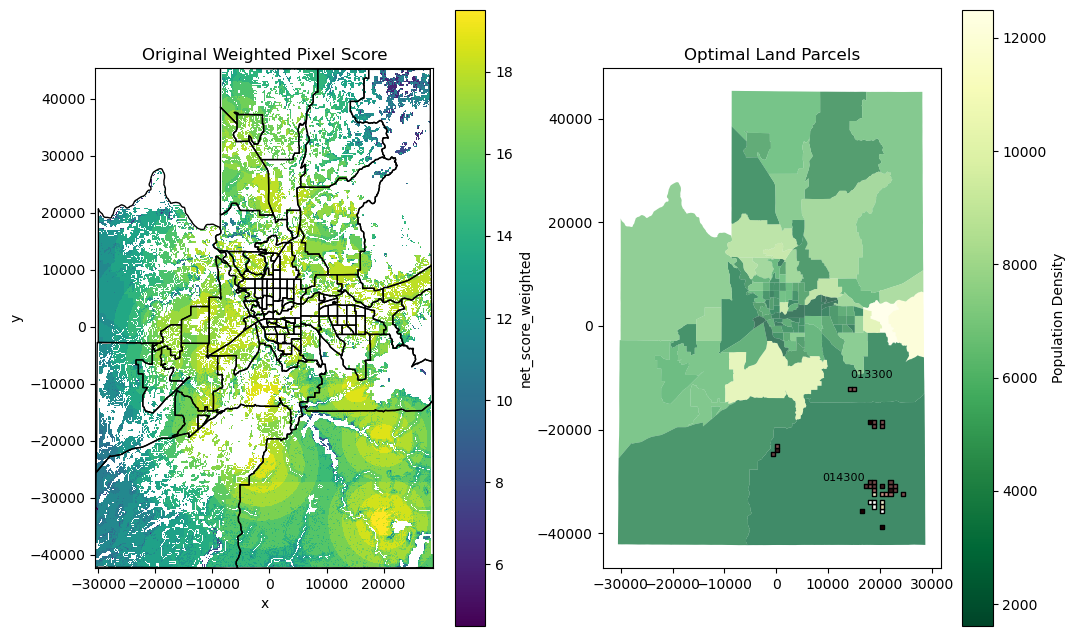

In [47]:
fig, ax = plt.subplots(1,2,figsize=(12, 8))

#Plots the unwieghted score and the tract lines
scale.net_score_weighted.plot(ax=ax[0])
tract_geom_gdf.plot(ax=ax[0], facecolor = 'none')

#Plots the poluation census data and locations of the solar farms
census_Spokane_gdf.plot(ax=ax[1], column="TotalPopulation",cmap="YlGn_r", legend=True, alpha=0.75, legend_kwds={"label":"Population Density"})
potential_solar_gdf_filter.plot(column="net_score", cmap="pink", edgecolor="black", ax=ax[1])


#Add text for each tract with a potential solar farm inside
for x, y, label in zip(tract_geom_gdf_fil.geometry.centroid.x, tract_geom_gdf_fil.geometry.centroid.y, tract_geom_gdf_fil.index):
    ax[1].text(x, y, label, fontsize=8, ha='center', va='center', color='Black')


ax[1].set_title("Optimal Land Parcels")
ax[0].set_title("Original Weighted Pixel Score")


plt.show()

In [48]:
solar_lands_itin_coord = potential_solar_gdf_filter.to_crs(4326)
solar_lands_itin_coord.head()

,net_score,geometry
709,1468.0,"POLYGON ((-117.42216 47.41414, -117.42216 47.4..."
733,1463.0,"POLYGON ((-117.41184 47.42114, -117.41184 47.4..."
734,1471.0,"POLYGON ((-117.41184 47.42815, -117.41184 47.4..."
1279,1472.0,"POLYGON ((-117.22559 47.52609, -117.22556 47.5..."
1317,1472.0,"POLYGON ((-117.21524 47.52607, -117.21521 47.5..."


# Section  7: Conclusion

### Challenges

The main challenge in this project was accessing the data. Many of the geojsons we wanted to use were behind paywalls that we luckily were able could work around thanks to the UW providing us ArcGIS accounts, but it was still a large initial obstacle. Another challenge we faced as a team was choosing the right scope of our project. Initially, we had planned on completing a much larger project. But, aquiring our data proved to be much more difficult than anticipated, we were forced to fine-tune our plan and focus on what was feasible in the given time frame and with our current abilities. 

### Future direction 

In the future, we would like to incorporate an energy generation calculation based on average seasonal sunlight for each of the 150-acre land plots. We would also like to include roadways into our map, something that did not occur to us until too late. Lastly, we would like to look more into the social economics of the area, examining how the different solar farm locations might affect the people in that area, whether it be detracting from their income source or providing cheaper long-term electricity.